# Fronteira eficiente Markovitz

Harry Markowitz criou em 1952 uma teoria que analise o **risco** de uma carteira de investimento.

O objetivo do modelo é criar um portfólio que otimiza o **risco-retorno** dos investimentos disponíveis, **escolhendo os pesos ideais pra cada ativo na carteira.**

In [ ]:
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [ ]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31)

In [ ]:
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]
#lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = pdr.get_data_yahoo(lista_acoes, inicio, final)['Adj Close']
precos

In [ ]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() #retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov() 
media_retornos

In [ ]:
numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos
    
    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    tabela_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    tabela_sharpe[k] = tabela_retornos_esperados[k]/tabela_volatilidades_esperadas[k]

In [34]:
indice_do_sharpe_maximo = tabela_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo]

array([0.24125169, 0.00258061, 0.08712275, 0.02941673, 0.58496207,
       0.05466615])

In [ ]:
["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]

In [ ]:
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

In [32]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), 
                                         tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) 
limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    
    #vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol,peso_inicial,method='SLSQP', bounds=limites, 
                      constraints=restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])
    

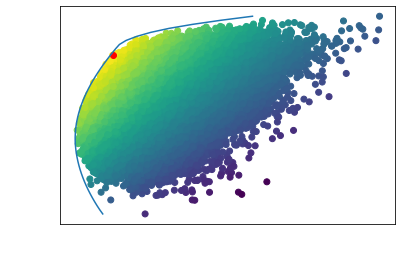

In [33]:
fig, ax = plt.subplots()

ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c = tabela_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.scatter(tabela_volatilidades_esperadas[indice_do_sharpe_maximo], 
            tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()